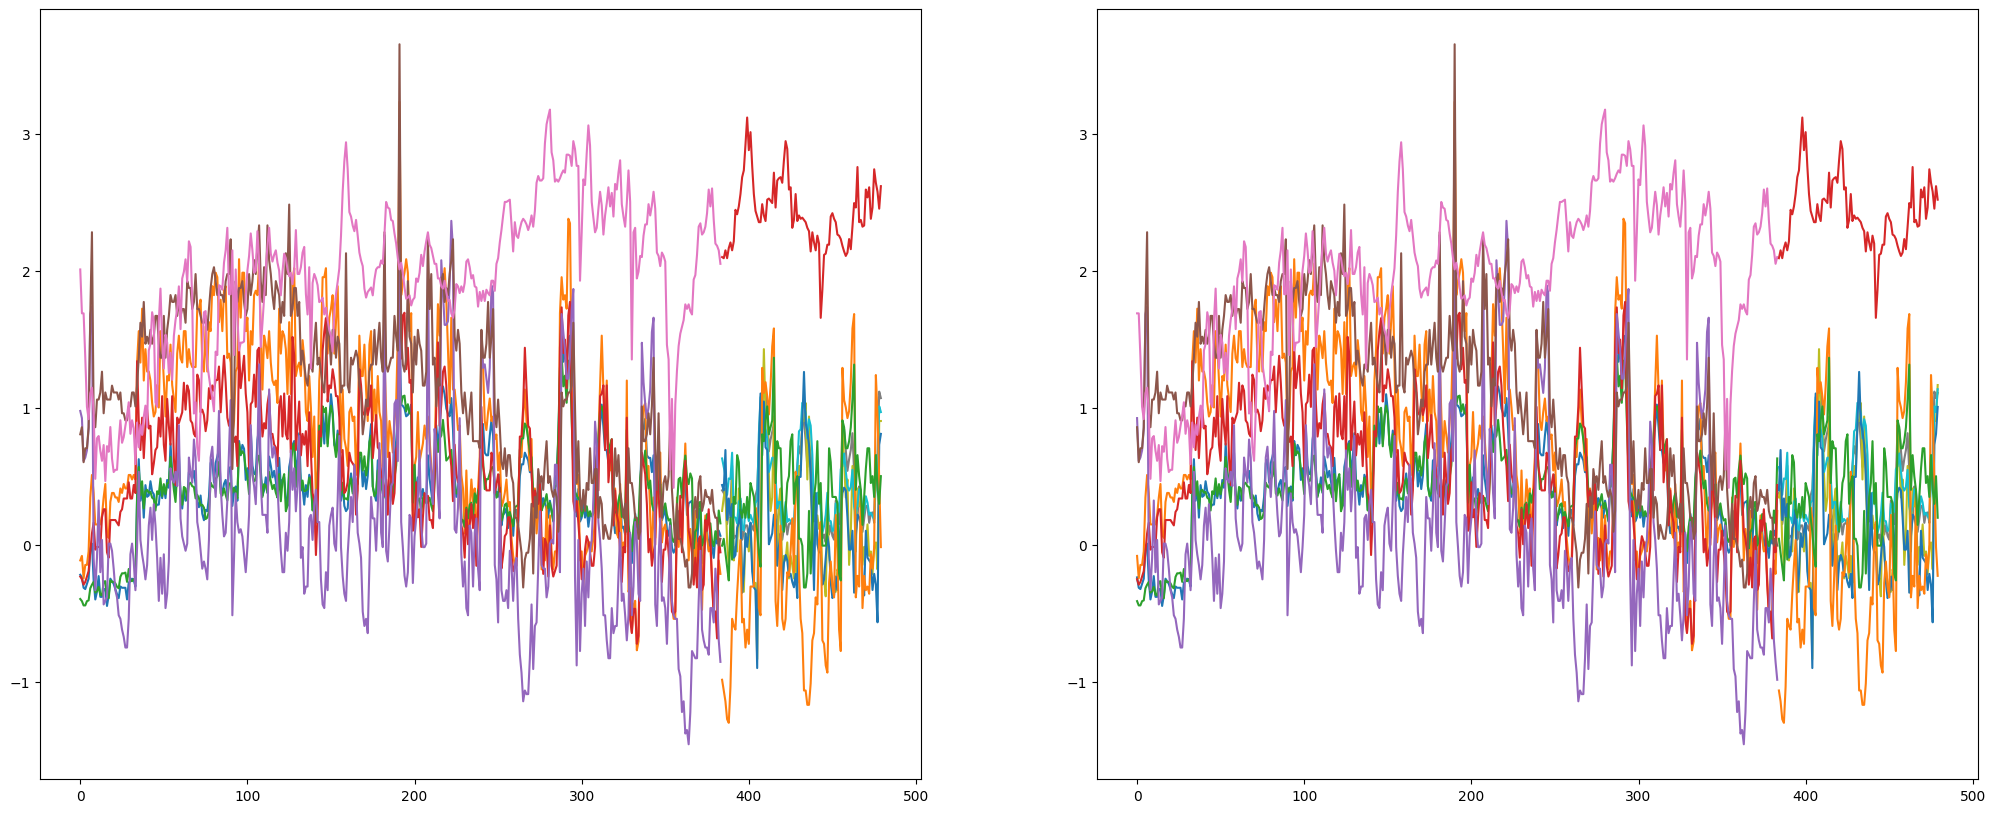

In [1]:
import pandas as pd
import numpy as np
from numpy import ndarray
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, clear_output

class TimeSeriesDataset(Dataset):
    def __init__(self, data: ndarray, seq_len: int = 384, pred_len: int = 96):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, idx):
        start = idx
        end = idx + self.seq_len
        x = self.data[start:end]
        y = self.data[end : end + self.pred_len]
        return (torch.tensor(x, dtype=torch.float32), 
                torch.tensor(y, dtype=torch.float32))


def load_and_process_data(
    filepath: str,
    target_columns: List[str],
    all_cols: bool = True,
    test_size: float = 0.2,
    normalize: bool = True,
):
    df = pd.read_csv(filepath)

    if all_cols:
        target_columns = df.columns[1:]

    data = df[target_columns].values

    if normalize:
        scaler = StandardScaler()
        data = scaler.fit_transform(data)

    train_data, test_data = (
        data[: -int(len(data) * test_size)],
        data[-int(len(data) * test_size) :],
    )

    return train_data, test_data


def create_dataloaders(
    train_data: ndarray,
    test_data: ndarray,
    seq_len: int = 384,
    pred_len: int = 96,
    batch_size: int = 64,
):
    train_dataset = TimeSeriesDataset(train_data, seq_len, pred_len)
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


# Usage example
filepath = "../data/ETTh1.csv"
datetime_column = "date"
target_columns = ["OT", "LULL"] 
seq_len = 384
pred_len = 96
batch_size = 64

train_data, test_data = load_and_process_data(filepath, target_columns)
train_loader, test_loader = create_dataloaders(
    train_data, test_data, seq_len, pred_len, batch_size
)

def plot_batch(data_set, batch_size=1):
    fig, axs = plt.subplots(1, batch_size, figsize=(25, 10))
    for i in range(batch_size):
        input_seq = train_loader.dataset[i][0]
        pred_seq = train_loader.dataset[i][1]
        axs[i].plot(input_seq, label="input sequence")
        axs[i].plot(np.arange(len(input_seq), len(input_seq) + len(pred_seq)), pred_seq, label='output sequence')
    plt.show()

plot_batch(train_data, 2)

In [2]:
class Model(nn.Module):
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.individual = configs.individual
        self.channels = configs.enc_in

        self.dominance_freq=configs.cut_freq # 720/24
        self.length_ratio = (self.seq_len + self.pred_len)/self.seq_len

        if self.individual:
            self.freq_upsampler = nn.ModuleList()
            for i in range(self.channels):
                self.freq_upsampler.append(nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat))

        else:
            self.freq_upsampler = nn.Linear(self.dominance_freq, int(self.dominance_freq*self.length_ratio)).to(torch.cfloat) # complex layer for frequency upsampling

    def forward(self, x):
        # RIN 
        x_mean = torch.mean(x, dim=1, keepdim=True)
        x = x - x_mean
        x_var = torch.var(x, dim=1, keepdim=True) + 1e-5
        x = x / torch.sqrt(x_var)

        low_specx = torch.fft.rfft(x, dim=1)

        low_specx[:,self.dominance_freq:] = 0 # LPF
        low_specx = low_specx[:,0:self.dominance_freq,:] # LPF

        if self.individual:
        
            low_specxy_ = torch.zeros(
                [low_specx.size(0),
                 int(self.dominance_freq * self.length_ratio),
                 low_specx.size(2)],
                 dtype=low_specx.dtype).to(low_specx.device)
            
            for i in range(self.channels):
                low_specxy_[:,:,i] = self.freq_upsampler[i](
                    low_specx[:,:,i]
                    .permute(0,1)
                    ).permute(0,1)
        else:
            low_specxy_ = self.freq_upsampler(
                low_specx
                .permute(0,2,1)
                ).permute(0,2,1)
                
            
        low_specxy = torch.zeros([
            low_specxy_.size(0),
            int((self.seq_len + self.pred_len) / 2 + 1 ),
            low_specxy_.size(2)],
            dtype=low_specxy_.dtype
            ).to(low_specxy_.device)
        
        
        low_specxy[:, 0:low_specxy_.size(1), :] = low_specxy_ 


        low_xy = torch.fft.irfft(low_specxy, dim=1)


        low_xy = low_xy * self.length_ratio
        
        xy = (low_xy) * torch.sqrt(x_var) + x_mean

        return xy #, low_xy * torch.sqrt(x_var)

In [3]:
@dataclass
class Config:
    seq_len: int = seq_len
    pred_len: int = pred_len
    individual: bool = True
    enc_in: int = train_data.shape[1]
    cut_freq: int = 20

model=Model(Config())
for param in model.parameters():
    param.data.fill_(0)

model(next(iter(train_loader))[0])


criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/module.py:1140: UserWarning: Complex modules are a new feature under active development whose design may change, and some modules might not work as expected when using complex tensors as parameters or buffers. Please file an issue at https://github.com/pytorch/pytorch/issues/new?template=bug-report.yml if a complex module does not work as expected.
  warnings.warn(


In [4]:
def train(model: nn.Module, config: Config, train_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, epochs: int = 1000):
    model.train()
    
    for epoch in tqdm(range(epochs), desc='Training Progress'):
        train_loss = []
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()

            output = model(batch_x)
            batch_xy = torch.cat([batch_x, batch_y], dim=1)

            loss = criterion(output, batch_xy)
            train_loss.append(loss.item())

            loss.backward()
            optimizer.step()

        clear_output(wait=True)
        display(f'Epoch: {epoch+1} Loss: {np.mean(train_loss)}')

    clear_output(wait=True)
    display(f'Final Loss: {np.mean(train_loss)}')

In [5]:
train(model, Config, train_loader, criterion, optimizer, epochs=10)

'Final Loss: 0.23285228239981484'

In [6]:
# From FITS repo
def augmentation(augment_time):
    if augment_time == 'batch':
        return BatchAugmentation()
    elif augment_time == 'dataset':
        return DatasetAugmentation()


class BatchAugmentation():
    def __init__(self):
        pass

    def freq_mask(self,x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=1)
        xy_f = torch.fft.rfft(xy,dim=dim)
        m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=dim)
        return xy

    def freq_mix(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        xy_f = torch.fft.rfft(xy,dim=dim)
        
        m = torch.cuda.FloatTensor(xy_f.shape).uniform_() < rate
        amp = abs(xy_f)
        _,index = amp.sort(dim=dim, descending=True)
        dominant_mask = index > 2
        m = torch.bitwise_and(m,dominant_mask)
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        
        b_idx = np.arange(x.shape[0])
        np.random.shuffle(b_idx)
        x2, y2 = x[b_idx], y[b_idx]
        xy2 = torch.cat([x2,y2],dim=dim)
        xy2_f = torch.fft.rfft(xy2,dim=dim)

        m = torch.bitwise_not(m)
        freal2 = xy2_f.real.masked_fill(m,0)
        fimag2 = xy2_f.imag.masked_fill(m,0)

        freal += freal2
        fimag += fimag2

        xy_f = torch.complex(freal,fimag)
        
        xy = torch.fft.irfft(xy_f,dim=dim)
        return xy
    def noise(self,x,y,rate=0.05,dim=1):
        xy = torch.cat([x,y],dim=1)
        noise_xy = (torch.rand(xy.shape)-0.5) * 0.1
        xy = xy + noise_xy.cuda()
        return xy

    def noise_input(self,x,y,rate=0.05,dim=1):
        noise = (torch.rand(x.shape)-0.5) * 0.1
        x = x + noise.cuda()
        xy = torch.cat([x,y],dim=1)
        return xy
    
    def vFlip(self,x,y,rate=0.05,dim=1):
        # vertically flip the xy
        xy = torch.cat([x,y],dim=1)
        xy=-xy
        return xy
    
    def hFlip(self,x,y,rate=0.05,dim=1):
        # horizontally flip the xy
        xy = torch.cat([x,y],dim=1)
        # reverse the order of dim 1
        xy = xy.flip(dims=[dim])
        return xy
    
    def time_combination(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        
        b_idx = np.arange(x.shape[0])
        np.random.shuffle(b_idx)
        x2, y2 = x[b_idx], y[b_idx]
        xy2 = torch.cat([x2,y2],dim=dim)

        xy = (xy+xy2)/2
        return xy
    
    def magnitude_warping(self, x, y, rate=0.5, dim=1):
        pass

    def linear_upsampling(self, x, y, rate=0.5, dim=1):
        xy = torch.cat([x,y],dim=dim)
        original_shape=xy.shape
        # randomly cut a segment from xy the length should be half of it
        # generate a random integer from 0 to the length of xy
        start_point = np.random.randint(0,original_shape[1]//2)

        xy = xy[:,start_point:start_point+original_shape[1]//2,:]
        
        # interpolate the xy to the original_shape
        xy=xy.permute(0,2,1)
        xy = torch.nn.functional.interpolate(xy, scale_factor=2, mode='linear')
        xy=xy.permute(0,2,1)
        return xy


class DatasetAugmentation():
    def __init__(self):
        pass

    def freq_dropout(self, x, y, dropout_rate=0.2, dim=0, keep_dominant=True):
        x, y = torch.from_numpy(x), torch.from_numpy(y)

        xy = torch.cat([x,y],dim=0)
        xy_f = torch.fft.rfft(xy,dim=0)

        m = torch.FloatTensor(xy_f.shape).uniform_() < dropout_rate

        
        # amp = abs(xy_f)
        # _,index = amp.sort(dim=dim, descending=True)
        # dominant_mask = index > 5
        # m = torch.bitwise_and(m,dominant_mask)

        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=dim)

        x, y = xy[:x.shape[0],:].numpy(), xy[-y.shape[0]:,:].numpy()
        return x, y

    def freq_mix(self, x, y, x2, y2, dropout_rate=0.2):
        x, y = torch.from_numpy(x), torch.from_numpy(y)

        xy = torch.cat([x,y],dim=0)
        xy_f = torch.fft.rfft(xy,dim=0)
        m = torch.FloatTensor(xy_f.shape).uniform_() < dropout_rate
        amp = abs(xy_f)
        _,index = amp.sort(dim=0, descending=True)
        dominant_mask = index > 2
        m = torch.bitwise_and(m,dominant_mask)
        freal = xy_f.real.masked_fill(m,0)
        fimag = xy_f.imag.masked_fill(m,0)
        

        x2, y2 = torch.from_numpy(x2), torch.from_numpy(y2)
        xy2 = torch.cat([x2,y2],dim=0)
        xy2_f = torch.fft.rfft(xy2,dim=0)

        m = torch.bitwise_not(m)
        freal2 = xy2_f.real.masked_fill(m,0)
        fimag2 = xy2_f.imag.masked_fill(m,0)

        freal += freal2
        fimag += fimag2

        xy_f = torch.complex(freal,fimag)
        xy = torch.fft.irfft(xy_f,dim=0)
        x, y = xy[:x.shape[0],:].numpy(), xy[-y.shape[0]:,:].numpy()
        return x, y